# RASTER PROCESSING WITH GDAL PYTHON

## Loading Package

In [26]:
from osgeo import gdal, ogr, osr, gdal_array as gdarr
import os
import numpy as np
import matplotlib.pyplot as plt

## working directory and file management

In [17]:
# loading current working directory
os.getcwd()

'E:\\2021\\TMT\\scientific_computing\\materials\\Geocomputing\\3_raster_vector_integration\\data\\14_raster-vector_integration_data'

In [18]:
# change directory
os.chdir("E:\\2021\\TMT\\scientific_computing\\materials\\Geocomputing\\3_raster_vector_integration\\data\\14_raster-vector_integration_data")

In [19]:
# to see files within directory
os.listdir()

['2014.tif',
 '2014_day1_subset.tif',
 'NL_provinces.cpg',
 'NL_provinces.dbf',
 'NL_provinces.prj',
 'NL_provinces.qpj',
 'NL_provinces.shp',
 'NL_provinces.shp.xml',
 'NL_provinces.shx',
 'ovRoads.geojson']

In [23]:
# Load raster data (define none to refresh its property. pls check with GIS software)
raster = None
raster = gdal.Open("2014.tif")

In [21]:
print("file opened.")
if raster is not None:
    raster = None
    print("file closed.")

file opened.
file closed.


skip above cell and run previous cell of the above cell if problem occur

## Access to dataset size and projection

In [24]:
x = raster.RasterXSize
y = raster.RasterYSize
print("x size: ", x, " y size: ", y)
print()

x size:  300  y size:  350



In [25]:
p = raster.GetProjection()
print("raster projection :", p )
print()

raster projection : PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],TOWGS84[565.4171,50.3319,465.5524,-0.398957,0.343988,-1.8774,4.0725],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28992"]]



## Affine Geotransform
The affine transform consists of six coefficients:
Xgeo = GT(0) + col*GT(1) + row*GT(2)
Ygeo = GT(3) + col*GT(4) + row*GT(5)

(GT(0), GT(3)): top-left corner of the image
GT(1): pixel width
GT(5): pixel height
Image is north up: GT(2) = GT(4) = 0
Not north up: GT(2) and GT(4) the rotation of x and y axis

In [27]:
raster.GetGeoTransform()

(0.0, 1000.0, 0.0, 640000.0, 0.0, -1000.0)

Top left corner of the image : (0.0, 640000); Spatial resolution (1000.0, -1000.0); Rotation of XY (0,0) 

## Access to band information

In [28]:
band = raster.GetRasterBand(1)
min = band.GetMinimum()
max = band.GetMaximum()
print("min value:", min, "max value", max)

stats = band.GetStatistics(False, True)

print("min = %.2f max = %.2f mean = %.2f std = %.2f" %
(stats[0], stats[1], stats[2], stats[3]))
print("no data value:", band.GetNoDataValue())
print("number of overviews:", band.GetOverviewCount())

min value: None max value None
min = 7.73 max = 10.50 mean = 9.19 std = 0.61
no data value: -9999.0
number of overviews: 0


## Convert from gdal to numpy

A gdal object can be converted into a numpy array. This allows to process
the raster with numpy. In the end, we can convert back the numpy object
to gdal.
BandReadAsArray() method converts a gdal band (one band) into a
numpy array.
DatasetReadAsArray() method converts a gdal dataset (all bands) into a
numpy array.

## Extraction of an individual pixel 

We need to import both gdal_array and gdal

In [29]:
# use 0;0 for the topleft pixel; -1; -1 for the bottomright
xoff = 100
yoff = 150
# use a window size of 1 pixel, this extracts one single pixel
win_xsize = 1
win_ysize = 1
px = gdarr.BandReadAsArray(band, xoff, yoff, win_xsize, win_ysize)
print(type(px))
print('shape', px.shape)
print("pixelvalue", px[0,0]) # Now it’s a numpy array. Order is y, x or Rows, Columns

<class 'numpy.ndarray'>
shape (1, 1)
pixelvalue 8.991154


## Plot an image subset with matplotlib

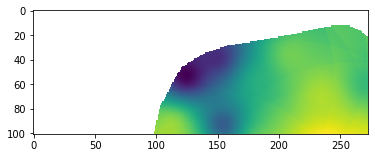

In [30]:
# use 0;0 for the topleft pixel; columns-1; rows-1 for the bottomright
xoff = 0
yoff = 0
win_xsize = 273
win_ysize = 101
px = gdarr.BandReadAsArray(band, xoff, yoff, win_xsize, win_ysize)
# replace nodata value by None
px[px == -9999] = None # or just use band.GetNoDataValue()
plt.imshow(px)
plt.show()

## Extract entire dataset (all bands) as a three-dim array

In [31]:
# use 0;0 for the topleft pixel;
xoff = 0
yoff = 0
# window size in pixels
win_xsize = 273
win_ysize = 101
px = gdarr.DatasetReadAsArray(raster, xoff, yoff, win_xsize, win_ysize)
print(type(px))
print('shape', px.shape)
print('topleft', px[0,0,0])
# Now it’s a numpy array. Order is - Day, y, x or Depth, Rows, Columns
print('bottomright', px[0,-1,-1])
# Now it’s a numpy array. order is - Day, y, x or Depth, Rows, Columns

<class 'numpy.ndarray'>
shape (365, 101, 273)
topleft -9999.0
bottomright 8.871047


## How to save a gdal raster image
Example converting from numpy to gdal
1 – Create a gdal driver with the preferred raster format (tif; img; csv;
arcinfo etc). This is needed to save the raster into a specific format.
2 – Create a new raster;
3 – Assign a projection to the new raster;
4 – Assign a geotransform to the new raster;
5 – Create one (or more) empty band/s;
6 – Write the numpy array to one or more bands;
band.WriteArray() method writes one two-dim numpy array into one
band.
7 – Set a no data value;
8 – Flush cache and clean the band variable to save data to disk.
9 - Set New band and New raster None to refresh values in the HDD.(check with GIS software or here)

In [32]:
band = raster.GetRasterBand(1)
xoff = 0
yoff = 0
win_xsize = 200
win_ysize = 200
arr = gdarr.BandReadAsArray(band, xoff, yoff, win_xsize, win_ysize)
#driver=raster.GetDriver() # Use the same format as the original image
# or
driver = gdal.GetDriverByName('GTiff') # we can choose a diferent format e.g. XYZ
newRaster = driver.Create('2014_day1_subset.tif',arr.shape[1],arr.shape[0], 1,
gdal.GDT_Float32)
prj = raster.GetProjection() # define new raster dataset proj. & geotransform
newRaster.SetProjection(prj)
newRaster.SetGeoTransform(raster.GetGeoTransform())
# We can use the same GT because TL is same
newBand = newRaster.GetRasterBand(1) # get band 1 so we can fill it with data
newBand.WriteArray(arr) # write the array to the band
newBand.SetNoDataValue(-9999) # set a pixel nodata value
newBand.FlushCache() # flush the cache and clean memory
newBand = None
newRaster = None
print("Finished!")

Finished!


In [34]:
raster_new = gdal.Open("2014_day1_subset.tif")

x1 = raster_new.RasterXSize
y1 = raster_new.RasterYSize
print("x1 size: ", x1, " y1 size: ", y1)
print()

x1 size:  200  y1 size:  200



In [35]:
p1 = raster.GetProjection()
print("raster projection :", p1 )
print()

raster projection : PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],TOWGS84[565.4171,50.3319,465.5524,-0.398957,0.343988,-1.8774,4.0725],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28992"]]



In [36]:
band1 = raster_new.GetRasterBand(1)
min1 = band1.GetMinimum()
max1 = band1.GetMaximum()
print("min value:", min1, "max value", max1)

stats1 = band1.GetStatistics(False, True)

print("min1 = %.2f max1 = %.2f mean1 = %.2f std1 = %.2f" %
(stats1[0], stats1[1], stats1[2], stats1[3]))
print("no data value:", band1.GetNoDataValue())
print("number of overviews:", band1.GetOverviewCount())

min value: None max value None
min1 = 7.73 max1 = 9.70 mean1 = 8.76 std1 = 0.44
no data value: -9999.0
number of overviews: 0


## gdal.Translate() 

performing subplotting
to convert raster data between different
formats, potentially performing some
operations like
• Subsettings,
• resampling, and
• rescaling pixels
in the process.

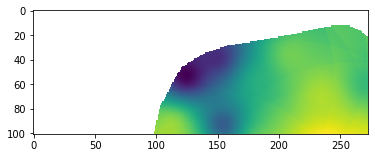

Finished.


In [12]:
# open dataset
raster = gdal.Open("2014.tif")
newDataset=gdal.Translate("2014_day1_subset.tif",raster,format="GTiff",srcWin=[0,0,273,101])
#To confirm let us show the raster image
newBand=newDataset.GetRasterBand(1)
px=gdarr.BandReadAsArray(newBand, 0, 0, newDataset.RasterXSize, newDataset.RasterYSize)
px[px == -9999] = None
plt.imshow(px)
plt.show()
print("Finished.")

## gdal.Warp() reprojecting

In this example we used format=“Mem“ therefore the result is not written
on disk, only returned by the method.
an image mosaicing, reprojection and
warping function

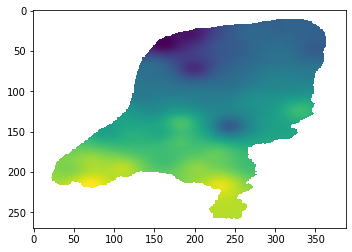

Finished.


In [14]:
# open dataset
raster = gdal.Open("2014.tif")
newDataset=gdal.Warp('',raster,format="Mem", dstSRS='EPSG:4326')
#To confirm let us show the raster image
newBand=newDataset.GetRasterBand(1)
px=gdarr.BandReadAsArray(newBand, 0, 0, newDataset.RasterXSize, newDataset.RasterYSize)
px[px == -9999] = None
plt.imshow(px)
plt.show()
print("Finished.")